In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa


# Hyper-parameters

In [37]:
SampleRate = 8000
Mu = 256
Batch = None
TimeLength = None
Dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
             1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
ReceptiveField = sum(Dilations) + 1
Hidden_channels = 32
Skip_channels = 256
Out_channels = Mu

# Data1 : LJSpeech-1.1 speech

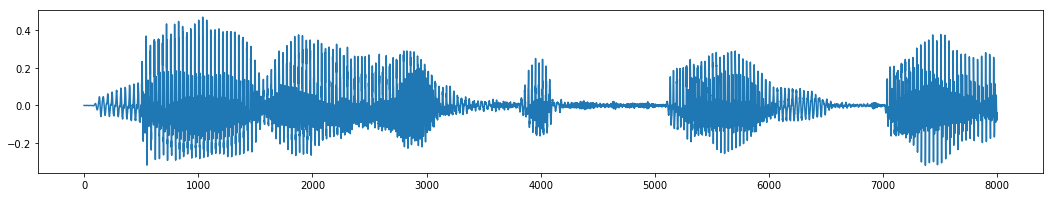

In [38]:
from os import listdir
from os.path import isfile, join
import ntpath

data_dir = '/home/scpark/ai/datasets/LJSpeech-1.1/wavs'
data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.wav' in f]

def get_data1(batch, time_length, sample_rate=SampleRate):
    
    read_length = 0
    waves = []
    while(read_length < batch * time_length):
        file_index = np.random.randint(0, len(data_files), 1)[0]
        wav, _ = librosa.core.load(data_files[file_index], sr=sample_rate)
        need_length = batch * time_length - read_length
        
        if len(wav) > need_length:
            wav = wav[:need_length]
            
        read_length += len(wav)
        waves.append(wav)
        
    waves = np.concatenate(waves)
    waves = np.reshape(waves, [batch, time_length])
    
    return waves
   
plt.figure(figsize=[18, 3])
plt.plot(get_data1(10, 8000)[0])
plt.show()

# Data2 : Sine Wave

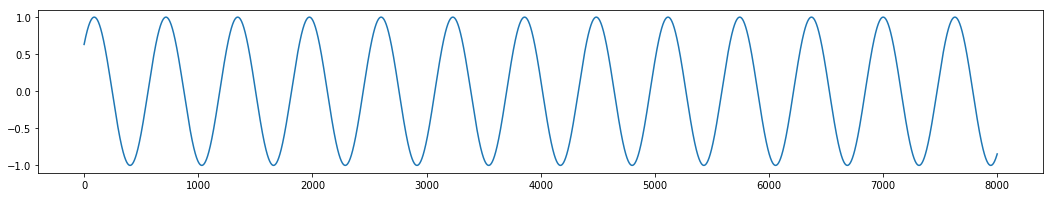

In [39]:
sine_x = np.linspace(0, 100000, 10000000)
sine_wave = np.sin(sine_x)

def get_data2(batch, time_length):
    start_index = np.random.randint(0, len(sine_wave) - (batch * time_length), 1)[0]
    end_index = start_index + (batch * time_length)
    data = sine_wave[start_index:end_index]
    data = np.reshape(data, [batch, time_length])
    return data

plt.figure(figsize=[18, 3])
plt.plot(get_data2(10, 8000)[0])
plt.show()

# Mu-Law Functions

In [16]:
def mulaw(x, Mu):
    return tf.sign(x) * tf.log(1. + Mu * tf.abs(x)) / tf.log(1. + Mu)

def inv_mulaw(x, Mu):
    return tf.sign(x) * (1. / Mu) * (tf.pow(tf.cast(1. + Mu, tf.float64), tf.cast(tf.abs(x), tf.float64)) - 1.)

def onehot_index(x, minimum, maximum, Mu):
    return tf.clip_by_value(tf.cast((x - minimum) / (maximum - minimum) * Mu, tf.int32), 0, Mu - 1)

def inv_onehot_index(x, minimum, maximum, Mu):
    return x / Mu * (maximum - minimum) + minimum



# Naive Wavenet

In [ ]:
def wavenet(x, dilations, 
            hidden_channels, skip_channels, out_channels, 
            name='wavenet', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        
        # x : [Batch, TimeLength, 256]
        
        residual_outputs = tf.layers.conv1d(x, filters=skip_channels, kernel_size=1)
        
        skips = []
        
        for dilation in dilations:
            layer_inputs = residual_outputs
            layer_inputs_paded = tf.pad(layer_inputs, [[0, 0], [dilation, 0], [0, 0]])
            
            filter_outputs = tf.layers.conv1d(layer_inputs_paded, filters=hidden_channels, kernel_size=2, dilation_rate=dilation)
            gate_outputs = tf.layers.conv1d(layer_inputs_paded, filters=hidden_channels, kernel_size=2, dilation_rate=dilation)
            
            layer_outputs = tf.nn.tanh(filter_outputs) * tf.nn.sigmoid(gate_outputs)
            
            skip_outputs = tf.layers.conv1d(layer_outputs, filters=skip_channels, kernel_size=1)
            skips.append(skip_outputs)
            
            residual_outputs = layer_inputs + skip_outputs
            
        outputs = sum(skips)
        outputs = tf.nn.relu(outputs)
        outputs = tf.layers.conv1d(outputs, filters=out_channels, kernel_size=1)
        outputs = tf.nn.relu(outputs)
        outputs = tf.layers.conv1d(outputs, filters=out_channels, kernel_size=1)
        
        return outputs

# Draw Graph

In [17]:
tf.reset_default_graph()

'''
Input Layer
'''

x = tf.placeholder(dtype=tf.float32, shape=[Batch, TimeLength])

# input for wavenet
x_expanded = tf.expand_dims(x, axis=-1)

# mu-law encoding
x_mulaw = mulaw(x, Mu)

# onehot vectors
x_onehot_index = onehot_index(x_mulaw, -1., 1., Mu)

'''
Wavenet Layer
'''

y = wavenet(tf.one_hot(x_onehot_index, Mu), Dilations, Hidden_channels, Skip_channels, Out_channels)

'''
Loss Layer
'''

cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=x_onehot_index[:, 1:], logits=y[:, :-1])
global_step = tf.Variable(0, name='global_step')
learning_rate = tf.placeholder(dtype=tf.float32, shape=())
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step)

'''
Sampling
'''

dist = tf.distributions.Categorical(probs=tf.nn.softmax(y))
sample = dist.sample()
sample = inv_onehot_index(sample, -1., 1., Mu)
sample = inv_mulaw(sample, Mu)
'''
Session Open
'''

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
#saver.restore(sess, "save/wavenet-5000")
print("Model restored.")

# tensorboard writer
cross_entropy_hist = tf.summary.scalar('cross_entropy', cross_entropy)
writer = tf.summary.FileWriter('save/wavenet', sess.graph)

print('graph create')


Model restored.
graph create


# Training Loop

step :  5192 cross entropy :  0.004401367


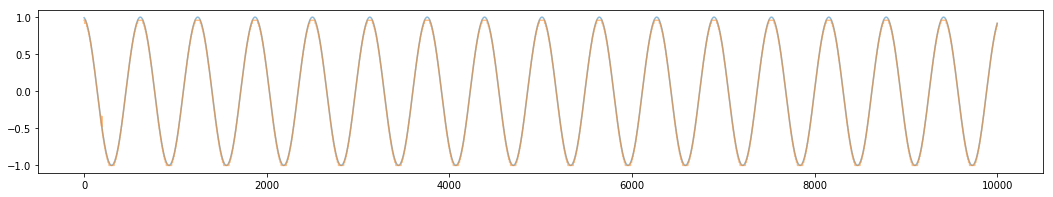

KeyboardInterrupt: 

In [26]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

# training parameters

loops = 100
batch = 1
time_length = 8000
_learninig_rate = 1e-4

while(True):
    _cross_entropies = []
    for _ in tqdm(range(loops)):
        _x = get_data(data_files, batch=batch, time_length=time_length)
        fetches = [train_step, global_step, cross_entropy, cross_entropy_hist, sample]
        _, _global_step, _cross_entropy, _cross_entropy_hist, _sample = sess.run(fetches, 
                                                                                 feed_dict={x: _x,
                                                                                           learning_rate: _learninig_rate})
        _cross_entropies.append(_cross_entropy)
        
        if _global_step % 100 == 0:
            writer.add_summary(_cross_entropy_hist, _global_step)
        
        if _global_step % 1000 == 0:
            save_path = saver.save(sess, 'save/wavenet', global_step=_global_step)
            print("Model saved in path: %s" % save_path)
        
    clear_output()
    
    print('step : ', _global_step, 'cross entropy : ', np.mean(_cross_entropies))
    
    plt.figure(figsize=[18, 3])
    plt.plot(_x[0], alpha=0.5)
    plt.plot(_sample[0], alpha=0.5)
    plt.show()
        

# Inference

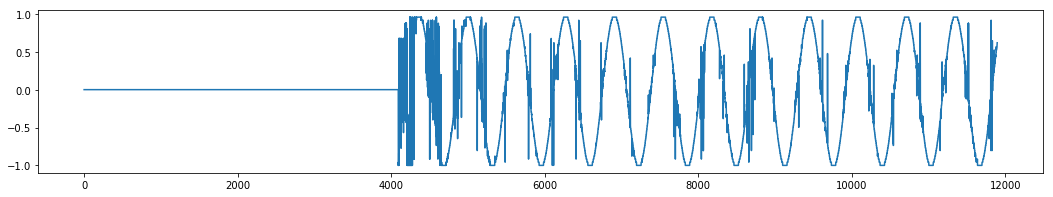

In [27]:
from IPython.display import clear_output

_inference = np.zeros([1, ReceptiveField])

for i in range(8000):
    _sample = sess.run(sample, feed_dict={x: _inference[:, -ReceptiveField:]})
    _inference = np.concatenate([_inference, _sample[:, -2:-1]], axis=1)
        
    if i % 200 == 0:
        clear_output()
        plt.figure(figsize=[18, 3])
        plt.plot(_inference[0])
        plt.show()

# Listen Audio

In [41]:
import IPython.display as ipd
ipd.Audio(_inference[0], rate=SampleRate)
